In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipycanvas import Canvas, hold_canvas
from IPython.display import display
import numpy as np
import matplotlib.cm as cm

# 2D 이미지 A와 포인트 정보 B를 받아 시각화하는 함수
def create_point_matching_tool(image_a, points_b, callback):
    # 클릭된 좌표를 저장할 리스트
    recorded_points = []

    # 출력 위젯 생성
    output = widgets.Output()

    # 왼쪽 이미지 캔버스 설정
    left_canvas = Canvas(width=image_a.shape[1], height=image_a.shape[0])
    with hold_canvas(left_canvas):
        left_canvas.put_image_data((image_a * 255).astype(np.uint8))

    # 오른쪽 포인트 캔버스 설정
    right_canvas = Canvas(width=image_a.shape[1], height=image_a.shape[0])
    u, v, d = points_b.T[:3]
    norm = plt.Normalize(vmin=0, vmax=d.max())
    cmap = cm.get_cmap('rainbow')
    with hold_canvas(right_canvas):
        for x, y, depth in zip(u, v, d):
            color = cmap(norm(depth))
            right_canvas.fill_style = f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})'
            right_canvas.fill_circle(x, y, 3)

    # 왼쪽 이미지 클릭 이벤트 핸들러
    def on_left_canvas_click(x, y):
        with output:
            print(f"Clicked on Image A at: ({x}, {y})")
            recorded_points.append({'image': 'A', 'coords': (x, y)})

    # 오른쪽 포인트 클릭 이벤트 핸들러
    def on_right_canvas_click(x, y):
        distances = np.sqrt((u - x) ** 2 + (v - y) ** 2)
        closest_index = np.argmin(distances)
        with output:
            print(f"Clicked on Projected Points B at index: {closest_index}")
            recorded_points.append({'image': 'B', 'index': closest_index, 'points': points_b[closest_index]})

        # 매칭된 좌표가 두 개가 되면 직선 그리기
        if len(recorded_points) >= 2 and recorded_points[-2]['image'] == 'A' and recorded_points[-1]['image'] == 'B':
            left_coords = recorded_points[-2]['coords']
            right_coords = (u[closest_index], v[closest_index])
            with hold_canvas(left_canvas):
                left_canvas.stroke_style = 'red'
                left_canvas.begin_path()
                left_canvas.move_to(left_coords[0], left_coords[1])
                left_canvas.line_to(right_coords[0], right_coords[1])
                left_canvas.stroke()
            with hold_canvas(right_canvas):
                right_canvas.stroke_style = 'red'
                right_canvas.begin_path()
                right_canvas.move_to(right_coords[0], right_coords[1])
                right_canvas.line_to(left_coords[0], left_coords[1])
                right_canvas.stroke()

    # 캔버스 클릭 이벤트 연결
    left_canvas.on_mouse_down(lambda x, y: on_left_canvas_click(x, y))
    right_canvas.on_mouse_down(lambda x, y: on_right_canvas_click(x, y))

    # 완료 버튼
    complete_button = widgets.Button(description="Complete Matching")

    # 완료 버튼 클릭 시 콜백 함수
    def on_complete(button):
        with output:
            # 콜백 함수 호출 (여기서는 예시로 print)
            if callback:
                callback(recorded_points)

    complete_button.on_click(on_complete)

    # 위젯과 캔버스 함께 가로로 표시
    canvas_box = widgets.HBox([left_canvas, right_canvas])
    display(widgets.VBox([canvas_box, complete_button, output]))

In [ ]:
import os
import cv2
import torch
import numpy as np 
from myutils.hy5py import calibration_property, get_frame_by_path, read_calibration
from myutils.points import lidar_points_to_disparity_with_cal, project_points_on_camera, refine_disparity_points, transform_point_inverse, transfrom_points
from myutils.widget import FrameExplorer
points = None
image = None
def on_frame(path: str):
    global points, image
    image = cv2.imread(os.path.join(path,"nir/left.png"))
    cal = read_calibration(os.path.join(os.path.dirname(path), "0.hdf5"))
    transform = np.load("jai_transform.npy")
    with get_frame_by_path(path) as frame:
        points = frame["lidar/points"][:].reshape(-1,3) 
        points = points[(points[:, 0] != 0) | (points[:, 1] != 0)]
        points = lidar_points_to_disparity_with_cal(points, transform, cal)
        points = refine_disparity_points(torch.from_numpy(points),).numpy()
        fx, bs, cx, cy = calibration_property(cal)
        points[:,2] = (fx * bs) / points[:,2]
        points[:,0] = (points[:,0] - cx) * points[:,2] / fx
        points[:,1] = (points[:,1] - cy) * points[:,2] / fx
        points = transfrom_points(points, transform)
    points_disp = transform_point_inverse(points, transform)
    #print(points_disp.shape, points.shape)
    points_disp = project_points_on_camera(points_disp, cal["mtx_left"][0,0], cal["mtx_left"][0,2], cal["mtx_left"][1,2])
    #print(points_disp.shape, points.shape)
    points = np.concatenate([points_disp, points], axis=1)
    
    points = points[(points[:,2] > 0) & (points[:,0] > 0) & (points[:,1] > 0) & (points[:,0] < 720) & (points[:,1] < 540)]
    
    
    
FrameExplorer(on_frame)

In [ ]:
path = "/bean/lucid/09_28_17_58/17_59_50_874"
image = cv2.imread(os.path.join(path,"left_rectified.png"), cv2.IMREAD_COLOR_BGR)
if os.path.exists(os.path.join(path,"points.npy")):
    points = np.load(os.path.join(path,"points.npy")).reshape(-1,3) * 1000
else:
    points = np.load(os.path.join(path,"raw.npz"))["points"].reshape(-1,3)
transform = np.load("jai_transform.npy")
transform[1,3] += 1000
# Extract the rotation part (3x3) from the 4x3 matrix
rotation_matrix = transform[:3, :3]

# Create a rotation matrix for 180 degrees around the Z-axis
theta = np.pi  # 180 degrees in radians
rotation_z_180 = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])

# Apply the rotation to the original rotation matrix
new_rotation_matrix = rotation_z_180 @ rotation_matrix

# Update the transform matrix with the new rotation matrix
transform[:3, :3] = new_rotation_matrix
points = points[(points[:, 0] != 0) | (points[:, 1] != 0)]
points_disp = transform_point_inverse(points.copy(), transform)
print(points_disp.shape)
cal = {**np.load("calibration_lucid.npz")}
points_disp = project_points_on_camera(points_disp, cal["mtx_left"][0,0], cal["mtx_left"][0,2], cal["mtx_left"][1,2])
#print(points_disp.shape, points.shape)
points = np.concatenate([points_disp, points], axis=1)

points = points[(points[:,2] > 0) & (points[:,0] > 0) & (points[:,1] > 0) & (points[:,0] < 1880) & (points[:,1] < 928)]

sc = plt.scatter(points[:,0], points[:,1], c=points[:,2] / 10000, vmin=0, vmax=10, cmap="magma")
plt.colorbar(sc)
c = points[...,2] / 10000 * 255

# depthmap = np.zeros(image.shape[:2])

# for i, p in enumerate(points):
#     cv2.circle(depthmap, (int(p[0]), int(p[1])), 3, c[i], -1)

# depthmap = depthmap.astype(np.uint8)
# depthmap = cv2.applyColorMap(depthmap, cv2.COLORMAP_MAGMA)
# cv2.imwrite("disparity.png",cv2.imread(os.path.join(path, "disparity.png")))
# plt.subplot(121)
# cv2.imwrite("depthmap.png", depthmap)
# cv2.imwrite("image.png", image)
# plt.imshow(depthmap)
# plt.axis('off')
# plt.subplot(122)
# plt.imshow(image)
# plt.axis('off')
# plt.tight_layout()
# plt.show()

In [ ]:
points_pair = []
def save_points(p):
    global points_pair
    points_pair = p
create_point_matching_tool(image, points, save_points)

In [46]:
points_uv_list = []
points_xyz_list = []

In [ ]:
point_a = []
point_b = []
for point in points_pair:
    if point['image'] == 'A':
        point_a.append(point['coords'])
        print(point['coords'])
    else:
        point_b.append(point['points'])
        print(point['points'][:2])

points_uv = np.array(point_a)
points_xyz = np.array(point_b)[:,3:]


points_uv_list.append(points_uv)
points_xyz_list.append(points_xyz)



In [ ]:
#cal = read_calibration("/bean/depth/09-20-13-45-57/0.hdf5")
K = cal["mtx_left"]
K

In [ ]:
import cv2
import numpy as np

# 3D LiDAR 포인트 (numpy array 형태, 크기: (n, 3))
lidar_points = points_xyz.astype(np.float32)

# 2D 이미지 좌표 (numpy array 형태, 크기: (n, 2))
image_points = points_uv.astype(np.float32)


# 왜곡 계수 (없다면 zeros 사용)
dist_coeffs = cal["dist_left"]

# solvePnP를 사용하여 회전 및 변환 벡터 계산
print(lidar_points.shape, image_points.shape, lidar_points.dtype, image_points.dtype)
success, rvec, tvec = cv2.solvePnP(lidar_points, image_points, K, dist_coeffs)

# 회전 벡터를 회전 행렬로 변환
R, _ = cv2.Rodrigues(rvec)

# 변환 행렬 M 구성 (크기: (4, 4))
M = np.eye(4)
M[:3, :3] = R
M[:3, 3] = tvec.flatten()

M

In [ ]:
print(np.linalg.pinv(M))
#np.save("jai_transform.npy", np.linalg.pinv(M))

In [ ]:
points = lidar_points_to_disparity_with_cal(np.load(os.path.join(path,"points.npy")), np.linalg.pinv(M), cal)
print(points.shape)


image_left = cv2.imread(os.path.join(path,"left_rectified.png"), cv2.IMREAD_COLOR_RGB)

plt.imshow(image_left)
plt.scatter(points[:,0], points[:,1], s=0.5, c=points[:,2], cmap='plasma',)
plt.colorbar()
plt.show()

In [ ]:
from myutils.points import refine_disparity_points
import torch

def plt_points(frame_path):
    with get_frame_by_path(frame_path) as frame:
        points = lidar_points_to_disparity_with_cal(frame["lidar/points"][:].reshape(-1,3), np.linalg.pinv(M), cal)
        points = refine_disparity_points(torch.from_numpy(points))
    image_left = cv2.imread(os.path.join(frame_path, "nir/left.png"))
    plt.imshow(image_left)
    plt.scatter(points[:,0], points[:,1], s=0.5, c=points[:,2], cmap='plasma',)
    plt.colorbar()
    plt.show()

FrameExplorer(plt_points)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 불러오기
full_image = cv2.imread('cross_spectral_figure.png')

# BGR 이미지를 RGB로 변환 (OpenCV는 BGR로 이미지를 로드하기 때문)
full_image_rgb = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)

# 사용자가 입력한 좌표
a_x = 14  # 이미지 A의 시작 x 좌표
a_y = 13   # 이미지 A의 y 좌표 (두 이미지의 y 좌표는 같다고 가정)
b_x = 2448  # 이미지 B의 시작 x 좌표
w = 780
h = 400
# 이미지 A와 B 잘라내기
A = full_image_rgb[a_y : a_y+h:, a_x:a_x + w]
B = full_image_rgb[a_y: a_y+h, b_x:b_x + w]

plt.imshow(A)
plt.show()
plt.imshow(B)
plt.show()

# 두 이미지의 세로 크기가 같도록 패딩 추가
max_height = max(A.shape[0], B.shape[0])
max_width = max(A.shape[1], B.shape[1])
# A와 B 이미지를 동일한 크기로 패딩
A_padded = np.pad(A, ((0, 0), (0, max_width - A.shape[1]), (0, 0)), mode='constant', constant_values=255)
B_padded = np.pad(B, ((0, 0), (0, max_width - B.shape[1]), (0, 0)), mode='constant', constant_values=255)

# B 이미지를 그레이스케일로 변환하여 밝기 값 기준으로 마스크 생성
B_gray = cv2.cvtColor(B_padded, cv2.COLOR_RGB2GRAY)
mask = B_gray >= 240

# 알파 채널을 포함한 새로운 이미지 생성 (RGBA)
overlay = np.zeros((B_padded.shape[0], B_padded.shape[1], 4), dtype=np.uint8)

# A의 RGB 값 복사
overlay[:, :, :3] = B_padded

# 마스크에 해당하는 픽셀에 대해 알파 값을 255로 설정 (투명도 없음)
overlay[mask, 3] = 255

print(A_padded.shape, overlay.shape)
# A와 overlay를 합성
A_with_overlay = cv2.addWeighted(A_padded, 0.5, overlay[:, :, :3], 0.5, 0, dtype=cv2.CV_32F)

# 결과 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(A_with_overlay.astype(np.uint8))
plt.axis('off')
plt.show()

In [69]:

import torch
import torch.nn.functional as F
def depth_to_normal_map(depth_map: torch.Tensor, fx: float, fy: float):
    # Calculate depth map gradients in x and y directions using Sobel filter
    dz_dx = F.conv2d(depth_map.unsqueeze(0).unsqueeze(0), torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], device=depth_map.device, dtype=depth_map.dtype) / 8, padding=1).squeeze()
    dz_dy = F.conv2d(depth_map.unsqueeze(0).unsqueeze(0), torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], device=depth_map.device, dtype=depth_map.dtype) / 8, padding=1).squeeze()
    
    # Calculate normal vectors
    normal_x = -dz_dx / fx
    normal_y = -dz_dy / fy
    normal_z = torch.ones_like(depth_map)

    normals = torch.stack((normal_x, normal_y, normal_z), dim=-1)
    norm = torch.norm(normals, dim=-1, keepdim=True)
    normals = normals / (norm + 1e-8)  # Normalize and prevent division by zero

    # Convert to RGB format (normalized to range 0~1)
    normal_map = (normals + 1) / 2
    return normal_map
def render_diffuse(normal_map: torch.Tensor, light_direction: torch.Tensor):
    # Calculate the dot product between the normal map and the light direction
    diffuse = torch.clamp(torch.sum(normal_map * -light_direction, dim=-1), 0, 1)
    return diffuse

def render_specular(normal_map: torch.Tensor, light_direction: torch.Tensor, view_direction: torch.Tensor, shininess: float):
    # Calculate the reflection direction
    reflection = 2 * torch.sum(normal_map * -light_direction, dim=-1, keepdim=True) * normal_map - light_direction

    # Calculate the dot product between the reflection direction and the view direction
    specular = torch.clamp(torch.sum(reflection * view_direction, dim=-1), 0, 1) ** shininess
    return specular

def compute_pointcloud(K: torch.Tensor, depth_map: torch.Tensor):
    height, width = depth_map.shape
    y, x = torch.meshgrid(torch.arange(height, device=depth_map.device), torch.arange(width, device=depth_map.device), indexing="ij")

    # Use camera intrinsic parameters fx, fy
    fx, fy = K[0, 0], K[1, 1]
    p_x = (x - width / 2) / fx * depth_map
    p_y = (y - height / 2) / fy * depth_map
    p_z = depth_map
    points = torch.stack((p_x, p_y, p_z), dim=-1)
    return points

def render_attenuation(K: torch.Tensor, depth_map: torch.Tensor, light_position: torch.Tensor, attenuation_factor: float = 1.0):
    points = compute_pointcloud(K, depth_map)
    # Calculate distance to the light source
    light_distance = torch.norm(points - light_position, dim=-1)

    # Calculate attenuation based on distance to the light source
    attenuation = 1 / (1 + attenuation_factor * light_distance ** 2)

    return attenuation, light_distance

def compute_spot_factor(light_direction: torch.Tensor, spot_direction: torch.Tensor, spot_exponent: float, cutoff_angle: float):
    # Calculate the angle between the light direction and spotlight direction
    cos_angle = light_direction* spot_direction.unsqueeze(0).unsqueeze(0)

    # Calculate the spotlight attenuation factor based on the cutoff angle
    spot_factor = torch.clamp((cos_angle - torch.cos(torch.tensor(cutoff_angle))) / (torch.cos(torch.tensor(spot_exponent)) - torch.cos(torch.tensor(cutoff_angle))), 0, 1)
    return spot_factor

def render(K: torch.Tensor, depth_map: torch.Tensor, light_position: torch.Tensor, view_direction: torch.Tensor, shininess: float, texture: torch.Tensor, intensity: float = 1.0, spot_exp=torch.pi / 4, spot_cutoff= torch.pi / 16):
    fx, fy = K[0, 0], K[1, 1]
    normal_map = depth_to_normal_map(depth_map.clone(), fx, fy)
    points = compute_pointcloud(K, depth_map)
    light_direction = light_position - points

    light_direction = light_direction / torch.norm(light_direction, dim=-1, keepdim=True)

    diffuse = render_diffuse(normal_map, light_direction.clone())

    specular = render_specular(normal_map, light_direction.clone(), view_direction, shininess)
    spot_factor = compute_spot_factor(-light_direction.clone(), view_direction, spot_exp, spot_cutoff)
    attenuation, light_distance = render_attenuation(K, depth_map, light_position)

    return (intensity  * attenuation * (diffuse + specular)  * (1-spot_factor[...,-1]))[..., None] * texture, [depth_map, diffuse, specular, spot_factor, attenuation, light_distance]
def peusdo_nir(rgb):
    # Reverse the channels and use torch.maximum
    interm = torch.maximum(rgb, 1 - rgb)

    # Compute the weighted sum and apply the power operation
    nir = (
        interm[..., 0] * 0.229 + interm[..., 1] * 0.587 + interm[..., 2] * 0.114
    ) ** (1 / 0.25)

    return nir

In [105]:
import random

class ImageItem:
    image: torch.Tensor
    depth_map: torch.Tensor
    material: torch.Tensor
    def __init__(self, image, depth_map, material):
        self.image = image
        self.depth_map = depth_map
        self.material = material
        

def random_light_render(K_tensor, baseline, item_left, item_right, light_position):
    device = K_tensor.device
    image_left, depth_map_left, _ = item_left.image, item_left.depth_map, item_left.material
    image_right, depth_map_right, _ = item_right.image, item_right.depth_map, item_right.material
    shaded_left = torch.zeros_like(image_left, dtype=torch.float32).to(device)
    shaded_right = torch.zeros_like(image_right, dtype=torch.float32).to(device)

    for i in range(10):
        light_z = random.randint(10, 100)
        intensity = 2 ** random.randint(5, 10)
        shininess=64
        light_position = torch.tensor([random.randrange(-1, 1) * light_z, random.randrange(-1, 1) * light_z, light_z], dtype=torch.float32).to(device)
        shaded, _ = render(K_tensor, depth_map_left, light_position=light_position + torch.tensor([baseline / 2, 0, 0], dtype=torch.float32).to(device), view_direction=torch.tensor([0, 0, 1], dtype=torch.float32).to(device), shininess=shininess, texture=image_left / 255, intensity=intensity)
        shaded_left += shaded
        shaded, _ = render(K_tensor, depth_map_right, light_position=light_position - torch.tensor([baseline / 2, 0, 0], dtype=torch.float32).to(device), view_direction=torch.tensor([0, 0, 1], dtype=torch.float32).to(device), shininess=shininess, texture=image_right / 255, intensity=intensity)
        shaded_right += shaded
    shaded_left = torch.clip(shaded_left, 0, 1)
    shaded_right = torch.clip(shaded_right, 0, 1)
    return shaded_left, shaded_right

/tmp/ipykernel_2134887/3627680401.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  depth_map_tensor = torch.tensor(depth_map, dtype=torch.float32).to(device)
/tmp/ipykernel_2134887/3627680401.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  depth_map_right_tensor = torch.tensor(depth_map_right, dtype=torch.float32).to(device)


0.10338020324707031


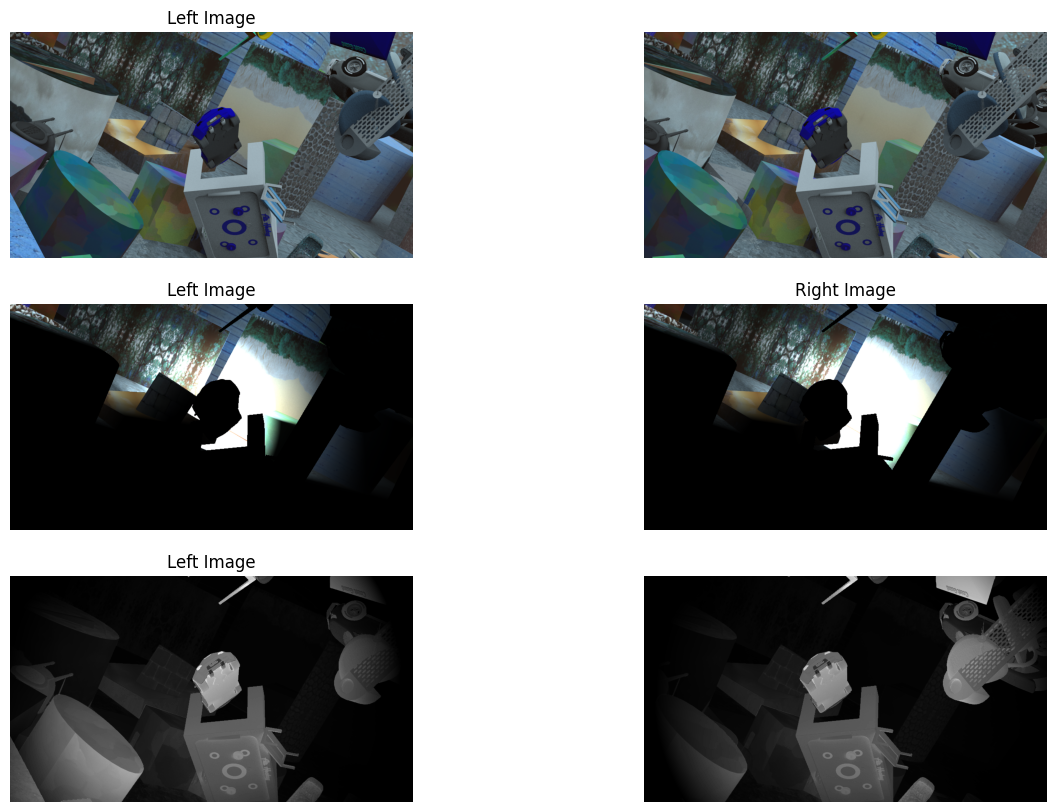

In [77]:
import sys
sys.path.append("/RAFT-Stereo")
import numpy as np
import time
from torch import normal
import pfmread
import cv2

path = "/bean/flyingthings3d/normal_map/TRAIN/A/0022/left/0006.pfm"

time_begin = time.time()
disparity_map = pfmread.read(path.replace("normal_map", "disparity"))
image_left = cv2.imread(
    path.replace("normal_map", "frames_cleanpass").replace("pfm", "png")
)
material_index = pfmread.read(path.replace("normal_map", "material_index"))[
    ..., np.newaxis
]
image_right = cv2.imread(
    path.replace("normal_map", "frames_cleanpass")
    .replace("left", "right")
    .replace("pfm", "png")
)
disparity_map_right = pfmread.read(
    path.replace("normal_map", "disparity").replace("left", "right")
)
material_index_right = pfmread.read(
    path.replace("normal_map", "material_index").replace("left", "right")
)[..., np.newaxis]
import matplotlib.pyplot as plt

image_left = torch.from_numpy(image_left).float()
image_right = torch.from_numpy(image_right).float()
image_nir = peusdo_nir(image_left / 255)[..., None]
image_nir_right = peusdo_nir(image_right / 255)[..., None]
disparity_map = torch.from_numpy(disparity_map.copy())
disparity_map_right = torch.from_numpy(disparity_map_right.copy())
material_index = torch.from_numpy(material_index.copy())
material_index_right = torch.from_numpy(material_index_right.copy())

K = np.array([[1050.0, 0.0, 479.5], [0.0, 1050.0, 269.5], [0.0, 0.0, 1.0]])


baseline = 1

depth_map = K[0, 0] * baseline / disparity_map
depth_map_right = K[0, 0] * baseline / disparity_map_right


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


image_left = image_left.to(device)
image_right = image_right.to(device)
image_nir = image_nir.to(device)
image_nir_right = image_nir_right.to(device)
disparity_map = disparity_map.to(device)
disparity_map_right = disparity_map_right.to(device)
material_index = material_index.to(device)
material_index_right = material_index_right.to(device)

K_tensor = torch.tensor(K, dtype=torch.float32).to(device)
depth_map_tensor = torch.tensor(depth_map, dtype=torch.float32).to(device)
depth_map_right_tensor = torch.tensor(depth_map_right, dtype=torch.float32).to(device)

shaded_left, shaded_right = random_light_render(
    K_tensor,
    baseline,
    ImageItem(image_left, depth_map_tensor, material_index),
    ImageItem(image_right, depth_map_right_tensor, material_index_right),
    torch.tensor([0, 0, -10], dtype=torch.float32).to(device),
    #1000,
)

light_position = torch.tensor([0, 0, -2], dtype=torch.float32).to(device)
shaded_nir, _ = render(
    K_tensor,
    depth_map_tensor,
    light_position=light_position
    - torch.tensor([baseline / 2, 0, 0], dtype=torch.float32).to(device),
    view_direction=torch.tensor([0, 0, 1], dtype=torch.float32).to(device),
    shininess=48,
    texture=material_index / 512 + image_nir,
    intensity=1500,
    spot_exp=torch.pi / 8,
    spot_cutoff=torch.pi / 16
)
shaded_nir_right, _ = render(
    K_tensor,
    depth_map_right_tensor,
    light_position=light_position
    + torch.tensor([baseline / 2, 0, 0], dtype=torch.float32).to(device),
    view_direction=torch.tensor([0, 0, 1], dtype=torch.float32).to(device),
    shininess=48,
    texture=material_index_right / 512 + image_nir_right,
    intensity=1500,
    spot_exp=torch.pi / 8,
    spot_cutoff=torch.pi / 16
)

print(time.time() - time_begin)
plt.figure(figsize=(15, 10))
plt.subplot(321)
plt.imshow(image_left.cpu() / 255)
plt.axis("off")
plt.title("Left Image")
plt.subplot(322)
plt.imshow(image_right.cpu() / 255)
plt.axis("off")
plt.subplot(323)
plt.imshow(shaded_left.cpu())
plt.axis("off")
plt.title("Left Image")
plt.subplot(324)
plt.imshow(shaded_right.cpu())
plt.axis("off")
plt.title("Right Image")
plt.subplot(325)
plt.imshow(shaded_nir.cpu(), cmap="gray")
plt.axis("off")
plt.title("Left Image")
plt.subplot(326)
plt.imshow(shaded_nir_right.cpu(), cmap="gray")
plt.axis("off")
plt.show()

In [10]:
def read_flying3d_frame(frame_path: str, term = "normal_map"):
    disparity_map = pfmread.read(frame_path.replace(term, "disparity").replace(".png",".pfm"))
    image_left = cv2.imread(
        frame_path.replace(term, "frames_cleanpass").replace("pfm", "png")
    )
    material_index = pfmread.read(frame_path.replace(term, "material_index").replace(".png",".pfm"))[
        ..., np.newaxis
    ]
    image_right = cv2.imread(
        frame_path.replace(term, "frames_cleanpass")
        .replace("left", "right")
        .replace("pfm", "png")
    )
    disparity_map_right = pfmread.read(
        frame_path.replace(term, "disparity").replace("left", "right").replace(".png",".pfm")
    )
    material_index_right = pfmread.read(
        frame_path.replace(term, "material_index").replace("left", "right").replace(".png",".pfm")
    )[..., np.newaxis]
    import matplotlib.pyplot as plt

    image_left = torch.from_numpy(image_left).float()
    image_right = torch.from_numpy(image_right).float()

    disparity_map = torch.from_numpy(disparity_map.copy())
    disparity_map_right = torch.from_numpy(disparity_map_right.copy())
    material_index = torch.from_numpy(material_index.copy())
    material_index_right = torch.from_numpy(material_index_right.copy())

    K = np.array([[1050.0, 0.0, 479.5], [0.0, 1050.0, 269.5], [0.0, 0.0, 1.0]])
    baseline = 1
    depth_map = K[0, 0] * baseline / disparity_map
    depth_map_right = K[0, 0] * baseline / disparity_map_right
    return ImageItem(image_left.cuda(), depth_map.cuda(), material_index.cuda()), ImageItem(image_right.cuda(), depth_map_right.cuda(), material_index_right.cuda())

In [109]:
def random_nir_render(item_left: ImageItem, item_right : ImageItem):
    light_position = torch.tensor([0, random.randint(-4,4), -2]).to(device)
    intensity = random.randint(1000,3000)
    spot_exp = torch.pi / (random.randint(4,8))
    left, _ = render(
        K_tensor,
        item_left.depth_map,
        light_position=light_position
        + torch.tensor([baseline / 2, 0, 0], dtype=torch.float32).to(device),
        view_direction=torch.tensor([0, 0, 1], dtype=torch.float32).to(device),
        shininess=48,
        texture=item_left.material /256 * peusdo_nir(item_left.image / 255)[...,None],
        intensity=intensity,
        spot_exp=spot_exp,
        spot_cutoff=torch.pi / 16
    )
    right, _ = render(
        K_tensor,
        item_right.depth_map,
        light_position=light_position
        - torch.tensor([baseline / 2, 0, 0], dtype=torch.float32).to(device),
        view_direction=torch.tensor([0, 0, 1], dtype=torch.float32).to(device),
        shininess=48,
        texture=item_right.material /256 * peusdo_nir(item_right.image / 255)[...,None],
        intensity=intensity,
        spot_exp=spot_exp,
        spot_cutoff=torch.pi / 16
    )
    return left,right

In [111]:
import os
def flying3d_frame_augment(frame_path: str, term="normal_map"):
    item_left, item_right = read_flying3d_frame(frame_path, term)
    for i in range(10):
        shaded_left, shaded_right = random_light_render(
            K_tensor,
            baseline,
            item_left,
            item_right,
            torch.tensor([0, 0, -10], dtype=torch.float32).to(device)
        )
        store_path_left = frame_path.replace(term, "frame_shaded").replace(".pfm",".png").replace(".png", f"_{i}.png")
        store_path_right = store_path_left.replace("left", "right")
        os.makedirs(os.path.dirname(store_path_left), exist_ok=True)
        os.makedirs(os.path.dirname(store_path_right), exist_ok=True)
        cv2.imwrite(store_path_left, (shaded_left.cpu().numpy() * 255).astype(np.uint8))
        cv2.imwrite(store_path_right, (shaded_right.cpu().numpy() * 255).astype(np.uint8))
        
        nir_left, nir_right = random_nir_render(item_left, item_right)
        store_path_left = store_path_left.replace("frame_shaded","frame_shaded_nir")
        store_path_right = store_path_left.replace("left", "right")
        os.makedirs(os.path.dirname(store_path_left), exist_ok=True)
        os.makedirs(os.path.dirname(store_path_right), exist_ok=True)
        cv2.imwrite(store_path_left, (np.clip(nir_left.cpu().numpy(), 0, 1) * 255).astype(np.uint8))
        cv2.imwrite(store_path_right, (np.clip(nir_right.cpu().numpy(), 0, 1) * 255).astype(np.uint8))


In [12]:
ROOT = "/bean/flyingthings3d/frames_cleanpass/TRAIN"
paths = []
for subdir in os.listdir(ROOT):
    for subsubdir in os.listdir(os.path.join(ROOT, subdir)):
        for frame in os.listdir(os.path.join(ROOT, subdir,  subsubdir, "left")):
            paths.append(os.path.join(ROOT, subdir, subsubdir,  "left",frame))
print(len(paths)) 

22398


In [112]:
from tqdm.notebook import tqdm
for path in tqdm(paths):
    try:
        #if os.path.exists(path.replace("frames_cleanpass", "frame_shaded").replace(".pfm",".png").replace(".png", "_0.png")):
        #    continue
        flying3d_frame_augment(path,"frames_cleanpass")
    except Exception:
        print(path , "failed")

  0%|          | 0/22398 [00:00<?, ?it/s]

KeyboardInterrupt: 

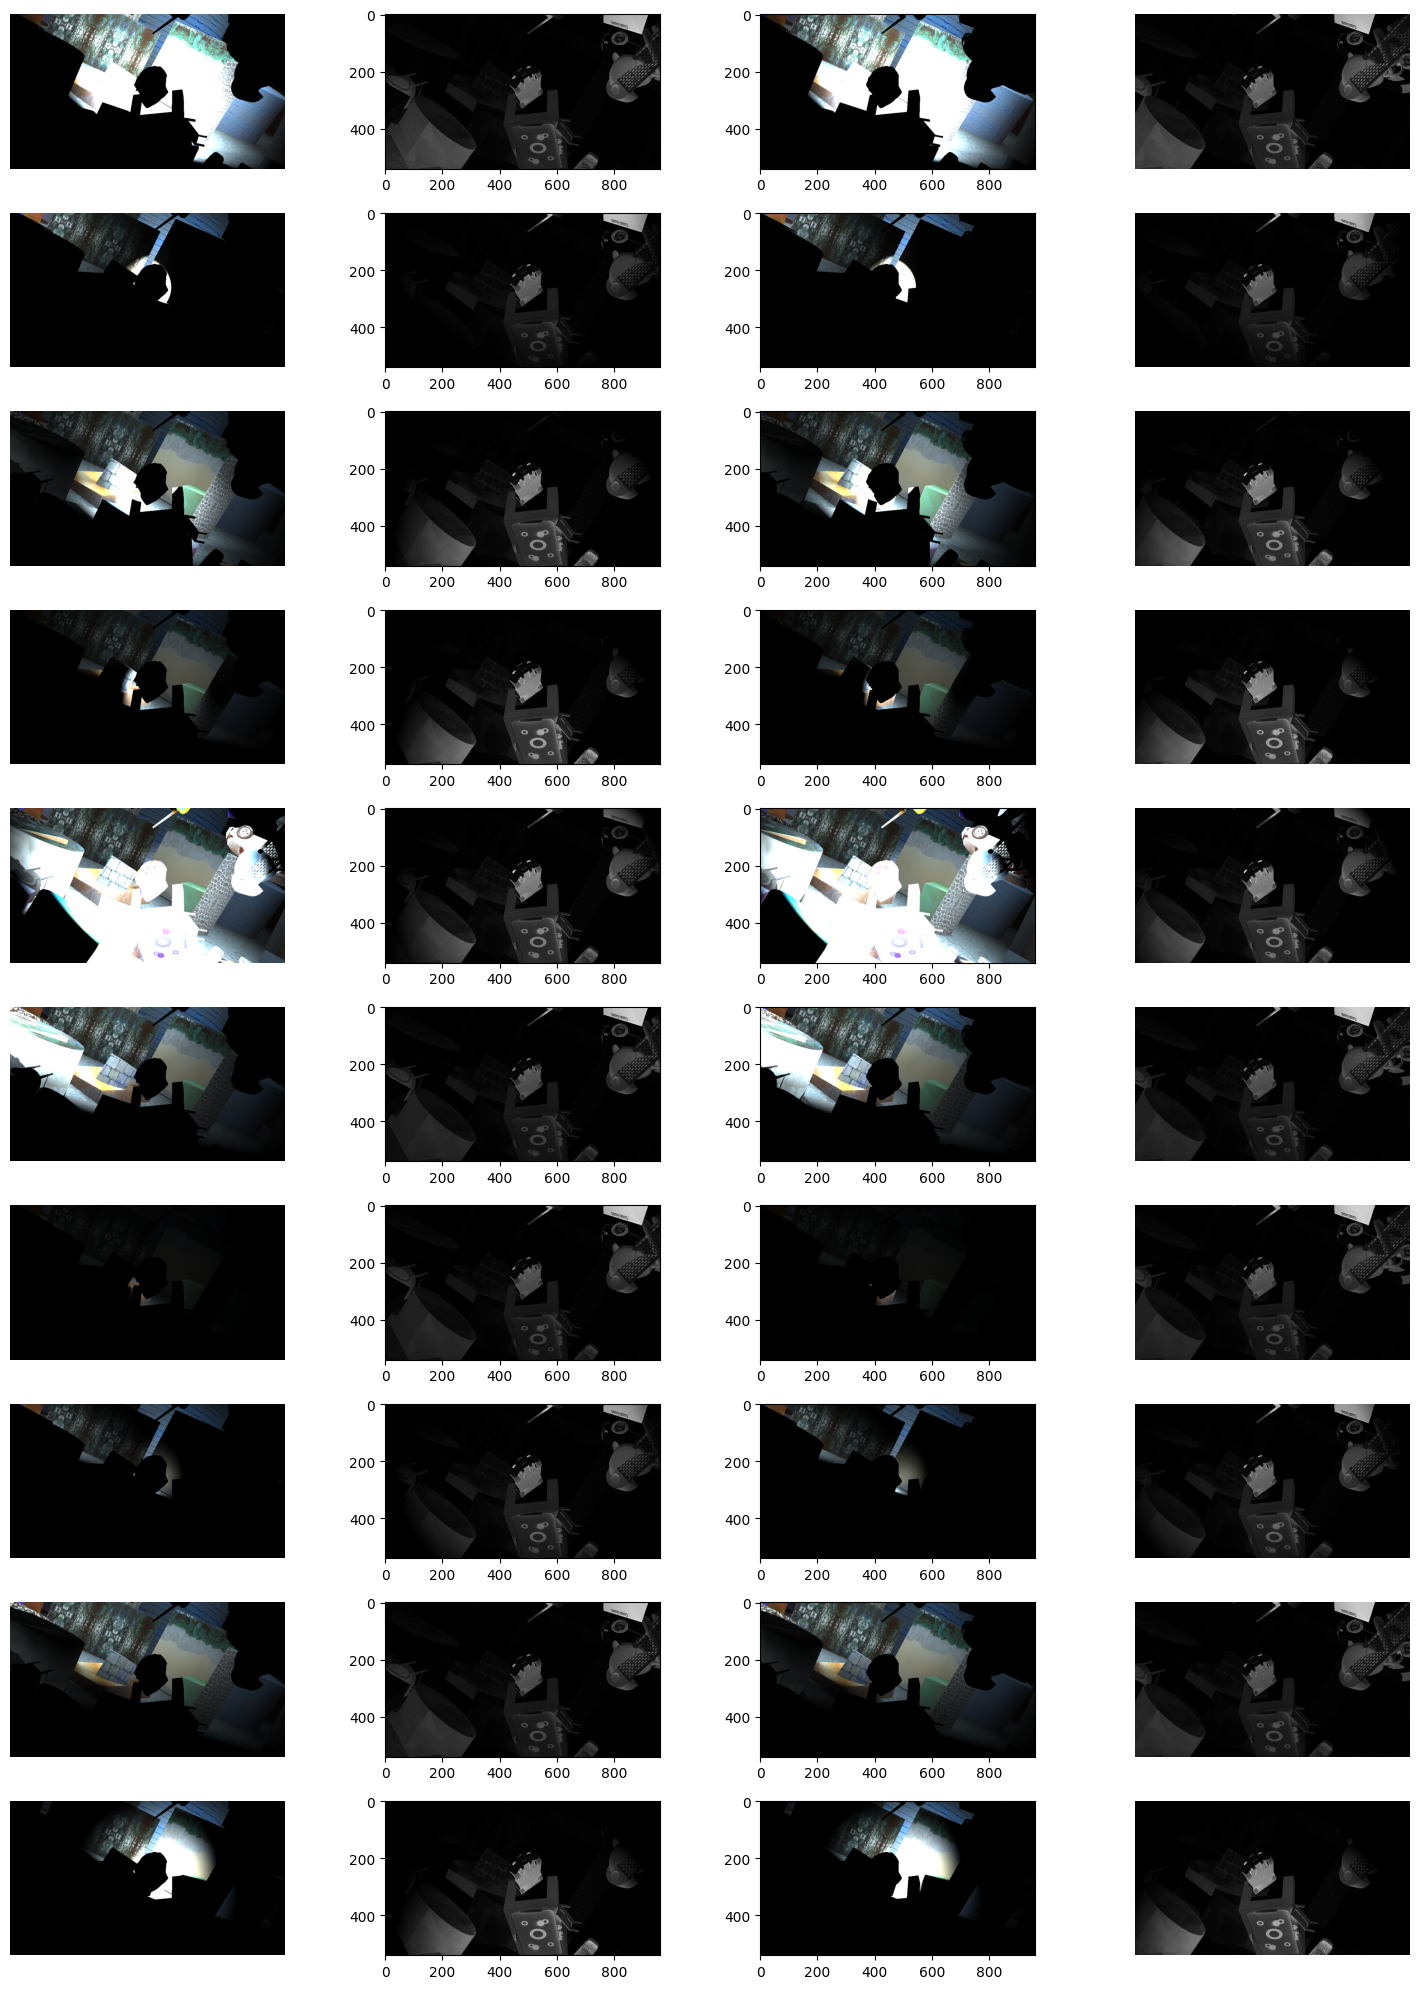

In [110]:
plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(10, 4, i * 4 + 1)
    shaded_left, shaded_right = random_light_render(
        K_tensor,
        baseline,
        ImageItem(image_left, depth_map_tensor, material_index),
        ImageItem(image_right, depth_map_right_tensor, material_index_right),
        torch.tensor([0, 0, -10], dtype=torch.float32).to(device),
    )
    shaded_nir, shaded_nir_right = random_nir_render(ImageItem(image_left, depth_map_tensor, material_index),
        ImageItem(image_right, depth_map_right_tensor, material_index_right),)
    plt.imshow(shaded_left.cpu())
    plt.axis("off")
    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(shaded_nir.cpu(), cmap="gray")
    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(shaded_right.cpu(), cmap="gray")
    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(shaded_nir_right.cpu(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()